In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.optimize import curve_fit
from utils.functions import PiecewiseLinear

In [27]:
data_path = (
    os.path.dirname(os.path.abspath("")) + "/analysis/plant_data/new_area_over_time.csv"
)
df = pd.read_csv(data_path).sort_values(by="timestamp")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")

sub_df0 = df[
    df["timestamp"].dt.date.isin(
        [
            pd.Timestamp("2025-02-26").date(),
            pd.Timestamp("2025-02-27").date(),
            pd.Timestamp("2025-02-28").date(),
        ]
    )
]
sub_df1 = df[
    df["timestamp"].dt.date.isin(
        [
            pd.Timestamp("2025-03-01").date(),
            pd.Timestamp("2025-03-02").date(),
            pd.Timestamp("2025-03-03").date(),
            pd.Timestamp("2025-03-04").date(),
            pd.Timestamp("2025-03-05").date(),
            pd.Timestamp("2025-03-06").date(),
            pd.Timestamp("2025-03-07").date(),
            pd.Timestamp("2025-03-08").date(),
            pd.Timestamp("2025-03-09").date(),
        ]
    )
]
sub_df2 = df[
    df["timestamp"].dt.date.isin(
        [
            pd.Timestamp("2025-03-09").date(),
            pd.Timestamp("2025-03-10").date(),
        ]
    )
]

In [28]:
# Number of time steps per day
sub_df0["timestamp"] = pd.to_datetime(sub_df0["timestamp"])
timestamps_per_day = sub_df0["timestamp"].dt.date.value_counts()
if timestamps_per_day.nunique() != 1:
    raise ValueError(f"Inconsistent timestamps per day: {timestamps_per_day.to_dict()}")
steps_per_day = timestamps_per_day.iloc[0]
print(f"steps_per_day={steps_per_day}")

# Number of time steps per night
time_increment = sub_df0["timestamp"].diff().mode()[0]
night_duration = (
    df.groupby(sub_df0["timestamp"].dt.date)["timestamp"].first().shift(-1)
    - sub_df0.groupby(sub_df0["timestamp"].dt.date)["timestamp"].last()
)
steps_per_night = int((night_duration.mode()[0] / time_increment) - 1)
print(f"steps_per_night={steps_per_night}")

steps_per_day=144
steps_per_night=144


/tmp/ipykernel_6035/2143248305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df0['timestamp'] = pd.to_datetime(sub_df0['timestamp'])


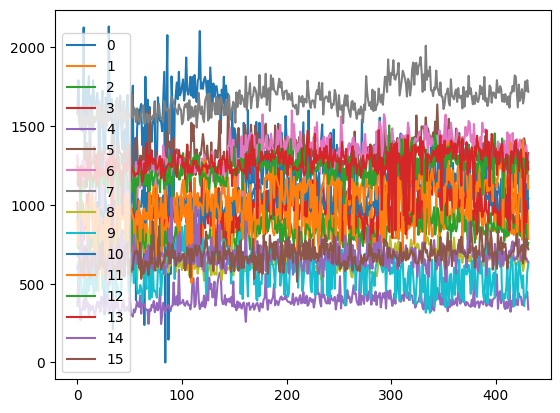

In [29]:
area0 = np.array(sub_df0.drop(columns=["timestamp"]))
for i in range(16):
    plt.plot(area0[:, i], label=i)
plt.legend()

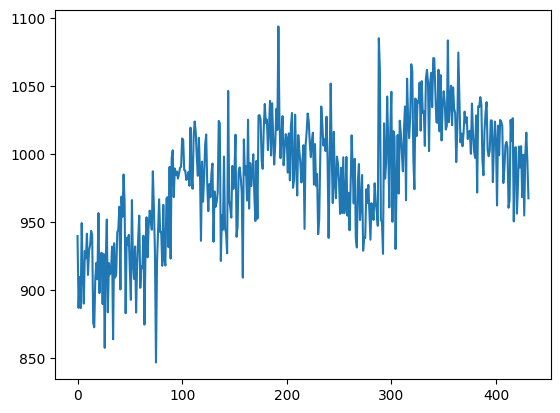

In [30]:
def iqm(values):
    outliers = 2
    values = np.sort(values)
    return np.mean(values[outliers : len(values) - outliers])
    # return np.mean(values[1:])


ave_area0 = [iqm(area0[i, :]) for i in range(area0.shape[0])]
ave_area0 = np.array(ave_area0)


def moving_average(x, trace_decay_rate=0.9):
    smooth_x = [x[0]]
    for i in range(1, len(x)):
        smooth_x.append(trace_decay_rate * smooth_x[-1] + (1 - trace_decay_rate) * x[i])
    return np.array(smooth_x)


plt.plot(ave_area0)

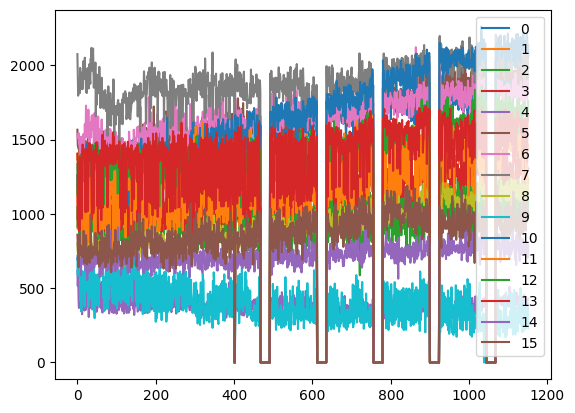

In [31]:
area1 = np.array(sub_df1.drop(columns=["timestamp"]))[: steps_per_day * 8, :]
for i in range(16):
    plt.plot(area1[:, i], label=i)
plt.legend()

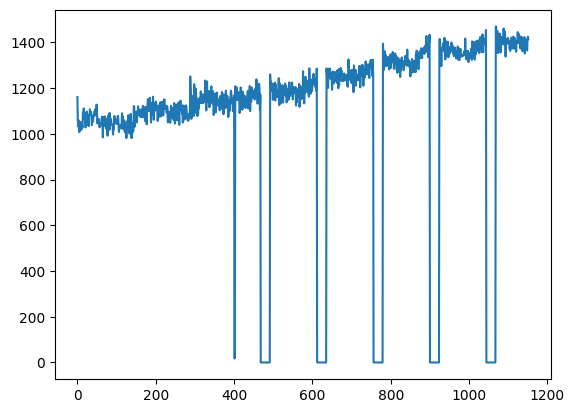

In [32]:
# Averaging all 16 plants
ave_area1 = [iqm(area1[i, :]) for i in range(area1.shape[0])]
ave_area1 = np.array(ave_area1)
plt.plot(ave_area1)

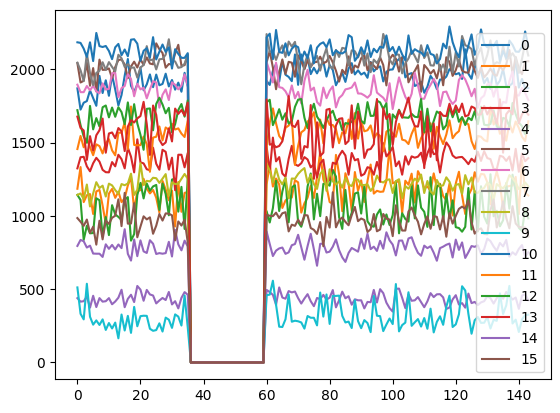

In [33]:
area2 = np.array(sub_df2.drop(columns=["timestamp"]))[13 : 13 + steps_per_day, :]
for i in range(16):
    plt.plot(area2[:, i], label=i)
plt.legend()

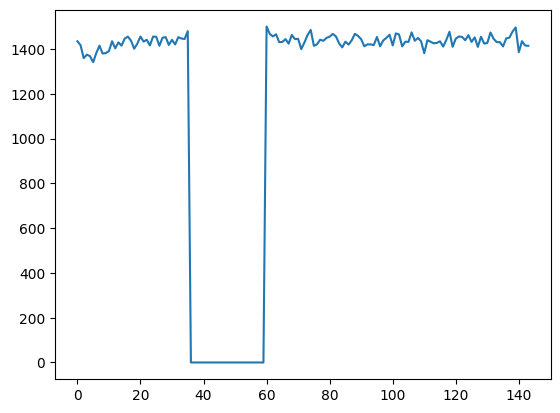

In [34]:
ave_area2 = [iqm(area2[i, :]) for i in range(area2.shape[0])]
ave_area2 = np.array(ave_area2)
plt.plot(ave_area2)

In [35]:
raw_ave_area = np.hstack([ave_area0, ave_area1, ave_area2])
print(len(raw_ave_area))
total_days = 12

1728


[135  48   0   0  49   0  60 116  60  35  60  60]
best fit power law ~ x^1.07


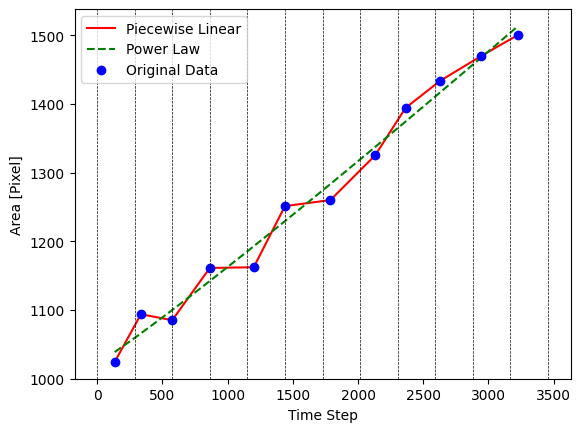

In [36]:
ave_area = np.zeros(total_days * steps_per_day)
ave_area[: len(raw_ave_area)] = raw_ave_area

observed_area = np.reshape(ave_area, (-1, steps_per_day))  # reshape into different days
max_indices = np.argsort(observed_area, axis=1)[
    :, -3
]  # index at the nth largest value of the day
max_indices = np.argmax(observed_area, axis=1)  # index at the max value of each day
print(max_indices)
# max_indices = [94,51,38,46,51,54,34, 34, 34, 34, 34, 34]

max_time = []
max_area = []
for i in range(observed_area.shape[0]):
    max_time.append(i * (steps_per_day + steps_per_night) + max_indices[i])
    max_area.append(ave_area[i * steps_per_day + max_indices[i]])

popt, pcov = curve_fit(lambda x, a, b, c: a * np.power(x, b) + c, max_time, max_area)
pwl = PiecewiseLinear(max_time, max_area)

x_values = np.linspace(max_time[0], max_time[-1], 1000)
y_power = popt[0] * np.power(x_values, popt[1]) + popt[2]
print(f"best fit power law ~ x^{popt[1]:.2f}")
y_linear = [pwl(x) for x in x_values]

# Plot
plt.plot(x_values, y_linear, "r-", label="Piecewise Linear")
plt.plot(x_values, y_power, "g--", label="Power Law")
plt.plot(max_time, max_area, "bo", label="Original Data")
for i in range(int(len(ave_area) / steps_per_day) + 1):
    plt.axvline(
        x=(steps_per_day + steps_per_night) * i,
        color="k",
        linestyle="--",
        linewidth=0.5,
    )
plt.xlabel("Time Step")
plt.ylabel("Area [Pixel]")
plt.legend()
plt.show()

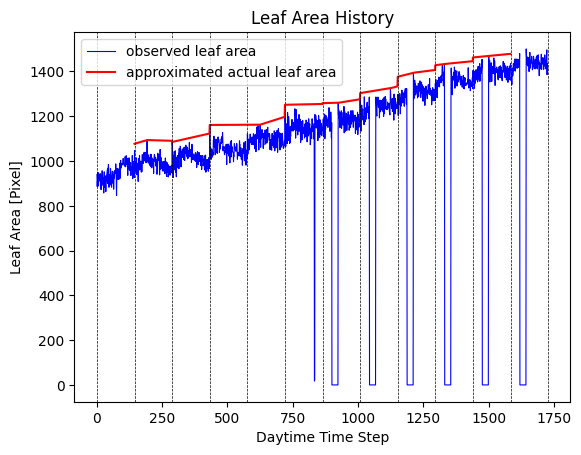

In [37]:
# Compute an array of actual area during daytime
actual_area_power = []
actual_area_linear = []
for i in range(1, observed_area.shape[0] - 1):
    t0 = i * (steps_per_day + steps_per_night)
    t1 = t0 + steps_per_day
    x_values = np.arange(t0, t1)
    y_power_values = popt[0] * np.power(x_values, popt[1]) + popt[2]
    y_linear_values = [pwl(x) for x in x_values]
    actual_area_power.append(y_power_values)
    actual_area_linear.append(y_linear_values)
actual_area_power = np.hstack(actual_area_power)
actual_area_linear = np.hstack(actual_area_linear)

# Plot the actual vs observed area
plt.plot(
    np.arange(0, total_days * steps_per_day),
    observed_area.reshape(-1),
    "b",
    label="observed leaf area",
    linewidth=0.8,
)
plt.plot(
    np.arange(steps_per_day, (total_days - 1) * steps_per_day),
    actual_area_linear,
    "r",
    label="approximated actual leaf area",
)
for i in range(int(len(ave_area) / steps_per_day) + 1):
    plt.axvline(x=(steps_per_day) * i, color="k", linestyle="--", linewidth=0.5)
plt.title("Leaf Area History")
plt.xlabel("Daytime Time Step")
plt.ylabel("Leaf Area [Pixel]")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Overday/overnight growth trend')

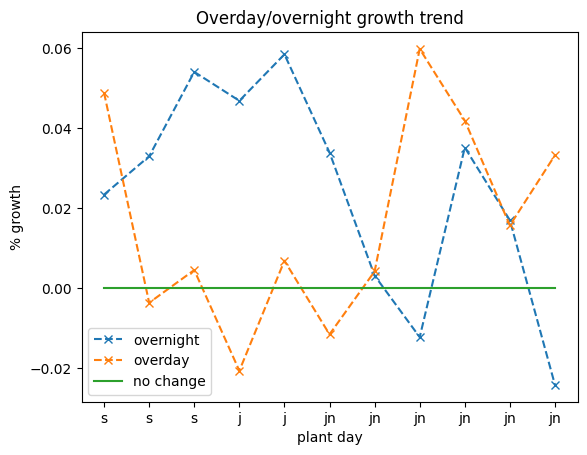

In [38]:
overnight_growth = [
    np.mean(ave_area[steps_per_day * i + 1 : steps_per_day * i + 4])
    / np.mean(ave_area[steps_per_day * i - 3 : steps_per_day * i])
    - 1
    for i in range(1, total_days)
]
plt.plot(np.arange(1, total_days), overnight_growth, "x--", label="overnight")
plt.xticks(
    np.arange(1, total_days),
    ["s", "s", "s", "j", "j", "jn", "jn", "jn", "jn", "jn", "jn"],
)
# s means days with standard policy, j means jetlag, jn means jetlag + nap
# note that the first 'jn' only had 10 min nap, the rest had 2 hr
plt.ylabel("% growth overnight")
plt.xlabel("plant day")

overday_growth = [
    np.mean(ave_area[steps_per_day * i - 3 : steps_per_day * i])
    / np.mean(ave_area[steps_per_day * (i - 1) + 1 : steps_per_day * (i - 1) + 4])
    - 1
    for i in range(1, total_days)
]
plt.plot(np.arange(1, total_days), overday_growth, "x--", label="overday")
plt.plot(np.arange(1, total_days), np.zeros(total_days - 1), label="no change")
plt.ylabel("% growth")
plt.xlabel("plant day")
plt.legend()
plt.title("Overday/overnight growth trend")

(0.0, 1440.0)

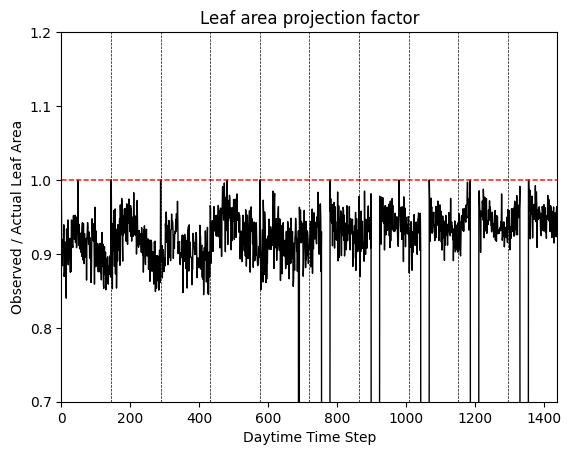

In [39]:
truncated_data = ave_area[steps_per_day:-steps_per_day]
projection_factor = truncated_data / actual_area_linear

plt.plot(projection_factor, "k", linewidth=1)
plt.plot(
    np.arange(len(projection_factor)),
    np.ones(len(projection_factor)),
    "r--",
    linewidth=1,
)
for i in range(int(len(ave_area) / steps_per_day) - 1):
    plt.axvline(x=(steps_per_day) * i, color="k", linestyle="--", linewidth=0.5)
plt.title("Leaf area projection factor")
plt.xlabel("Daytime Time Step")
plt.ylabel("Observed / Actual Leaf Area")
plt.ylim(0.7, 1.2)
plt.xlim(0, len(projection_factor))